In [18]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

from sklearn.model_selection import train_test_split

from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import (sklearn_sm, sklearn_selection_path, Stepwise, sklearn_selected)
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.pyplot import subplots

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']


### Choosing best degree for polynomial regression using cross validation

In [4]:
model_spec = MS([poly('age', degree=3)]).fit_transform(Wage)
model_spec[:5], Wage['age'][:5]

(   intercept  poly(age, degree=3)[0]  poly(age, degree=3)[1]  \
 0        1.0               -0.038625                0.055909   
 1        1.0               -0.029133                0.026298   
 2        1.0                0.004090               -0.014507   
 3        1.0                0.000926               -0.014831   
 4        1.0                0.012000               -0.009816   
 
    poly(age, degree=3)[2]  
 0               -0.071741  
 1               -0.014550  
 2               -0.000133  
 3                0.004514  
 4               -0.011137  ,
 0    18
 1    24
 2    45
 3    43
 4    50
 Name: age, dtype: int64)

[1604.01253415032]

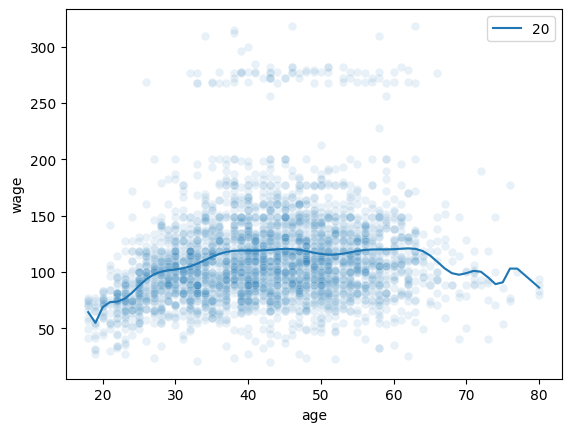

In [5]:
sns.scatterplot(data=Wage, x='age', y='wage', alpha=.1)
cv_list = []
for i in range(20,21):
    wage_model = sklearn_sm(sm.OLS,
                        MS([poly('age', degree=i)]))
    X, Y = Wage.drop(columns=['wage']), Wage['wage']
    cv_results = cross_validate(wage_model,
                                X,
                                Y,
                                cv=10)
    
    dir(cv_results)
    cv_err = np.mean(cv_results['test_score'])
    cv_list.append(cv_err)
    wage_model = sm.OLS(Y, MS([poly('age', degree=i)]).fit_transform(X)).fit()
    sns.lineplot(x=age, y=wage_model.predict(MS([poly('age', degree=i)]).fit_transform(X)), label=i)

cv_list

# Degree 4 polynomial regression seems to yield the best results, 
# coincides with anova results in choosing the best degree for the model

### Fitting a step function with the optimal number of cuts using cross validation

In [6]:
cut_age = pd.cut(age, 7)
cut_age
pd.get_dummies(cut_age)[:5]

,"(17.938, 26.857]","(26.857, 35.714]","(35.714, 44.571]","(44.571, 53.429]","(53.429, 62.286]","(62.286, 71.143]","(71.143, 80.0]"
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0


[-1601.5887253102176]

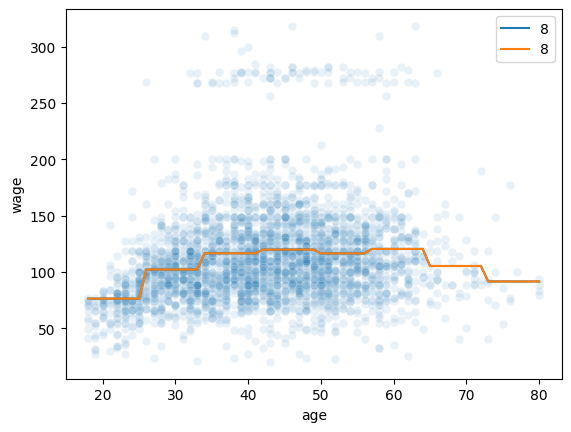

In [7]:
cv_list = []
for i in range(8,9):
    cut_age = pd.cut(Wage['age'], i)
    X, Y = pd.get_dummies(cut_age), Wage['wage']
    wage_model = LinearRegression()

    cv_results = cross_validate(wage_model,
                                X,
                                Y,
                                cv=5, scoring='neg_mean_squared_error')
    cv_err = np.mean(cv_results['test_score'])
    cv_list.append(cv_err)

    model = sm.OLS(Y,X).fit()
    wage_model = LinearRegression().fit(X,Y)
    sns.scatterplot(data=Wage, x='age', y='wage', alpha=.1)
    sns.lineplot(x=age, y=model.predict(X), label=i)
    sns.lineplot(x=age, y=wage_model.predict(X), label=i)


cv_list


# Step function for any predictor

In [8]:
Wage.head()


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [9]:
pd.get_dummies(Wage['education']).values
maritl =Wage['maritl'].astype('category').cat.codes
maritl
jobclass = Wage['jobclass'].astype('category').cat.codes
Wage['maritlcat'] = maritl
Wage['jobclasscat'] = jobclass

def categorize(string, do=False):
    if do:
        var = Wage[string].astype('category').cat.codes
        print(Wage[string].unique(), var.unique())
        Wage[str(string+'cat')] = var
        lis = [x for _,x in sorted(zip(var.unique(),Wage[string].unique()))]
        return str(string+'cat'), lis
    else: 
        return string, None

[-1741.3352300105812,
 -1733.278029620965,
 -1684.4148177270613,
 -1635.1934412744,
 -1632.936633937682,
 -1625.8803880599644,
 -1613.3836387967986]

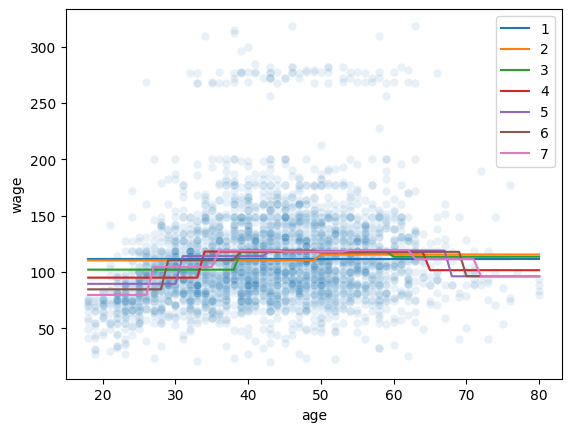

In [10]:
def step(predictor, range_):
    lab = predictor[1]
    predictor = predictor[0]
    if 'cat' in predictor:
        sns.boxplot(data=Wage, x=predictor, y='wage')
        plt.xlabel(lab)
    else:
        sns.scatterplot(data=Wage, x=predictor, y='wage', alpha=0.1,label=lab)

    cv_list = []
    for i in range(range_[0],range_[1]):
        cut_predictor = pd.cut(Wage[predictor], i)
        X, Y = pd.get_dummies(cut_predictor), Wage['wage']
        wage_model = LinearRegression()

        cv_results = cross_validate(wage_model,
                                    X,
                                    Y,
                                    cv=5, scoring='neg_mean_squared_error')
        cv_err = np.mean(cv_results['test_score'])
        cv_list.append(cv_err)

        model = sm.OLS(Y,X).fit()
        wage_model = LinearRegression().fit(X,Y)
        
        # sns.lineplot(x=Wage[predictor], y=model.predict(X), label=i)
        sns.lineplot(x=Wage[predictor], y=wage_model.predict(X), label=i)


    return cv_list

# step(categorize('race', do=True), (1,4))
step(categorize('age', do=False), (1,8))


# Exercises 11 and 12

In [11]:
import random
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Generating data

df = pd.DataFrame()
for i in range(10):
    df[f'x{i+1}'] = np.random.randint(0,10,20)

y = []
intercept = 5
coeffs = [5,5,69,7,7,677,9,9,9,1]
# coeffs = [1,2,3,4]
for i in range(df.shape[0]):
    associated_coeffs = []
    sum = intercept
    for j in range(len(df.columns)):
        sum += coeffs[j]*df[df.columns[j]].loc[i]
        associated_coeffs.append((df.columns[j], coeffs[j]))
    y.append(sum)

df['y'] = np.array(y)

df.head(30)
df[[x for x in df.columns if x !='x3']]

,x1,x2,x4,x5,x6,x7,x8,x9,x10,y
0,6,0,8,3,0,2,1,4,9,391
1,2,0,2,1,3,1,0,4,9,2328
2,9,1,3,4,2,5,5,9,2,1907
3,5,9,4,4,0,0,0,6,6,260
4,8,4,4,8,4,0,6,0,5,3330
5,8,5,0,5,5,5,7,4,1,4118
6,6,3,9,5,4,4,7,4,3,3270
7,3,6,7,8,8,6,2,6,6,5772
8,0,7,4,0,7,0,6,1,8,5499
9,8,6,0,2,4,8,6,2,3,3289


In [13]:
betas = [9,9,9,9,9,9,9,9,9,9,9]
betas_path = [[9],[9],[9],[9],[9],[9],[9],[9],[9],[9],[9]]

# betas = [9,9,9,9,9]
# betas_path = [[9], [9],[9],[9],[9]]

# for i in range(1000):
#     ftr = random.randint(1,10)
#     ftr_string = f'x{ftr}'
#     processed_df = pd.DataFrame()
#     processed_df = df[[x for x in df.columns if x !=ftr_string]]
#     sum = np.zeros(processed_df.shape[0])
#     for j in range(len(processed_df.columns)):
#         sum += betas[ftr]*processed_df[processed_df.columns[j]]
#     outcome = processed_df['y'] - sum



def simple_reg(outcome, feature):

    model = sm.OLS(outcome, feature, intercept=True).fit()
    return model.params

df['intercept'] = np.full(df.shape[0], 1)


for iteration in range(1000):
    ftr = (iteration%(df.shape[1]-2)+1)
    ftr_string = f'x{ftr}'
    processed_df = pd.DataFrame()
    processed_df = df[[x for x in df.columns if x not in [ftr_string, 'intercept', 'y']]]
    sum = np.zeros(processed_df.shape[0])
    
    for j in range(len(processed_df.columns)):
        sum += betas[int(str(processed_df.columns[j])[1:])]*processed_df[processed_df.columns[j]]
        # print(processed_df.columns[j], int(str(processed_df.columns[j])[1:]))
    # print(sum)
    # print('_')

    outcome = df['y'] - sum
    params = simple_reg(outcome, df[['intercept', ftr_string]])
    # print(params)
    betas[0] = round(params[0],2)
    betas[ftr] = round(params[1],2)
    betas_path[0].append(betas[0])
    betas_path[ftr].append(betas[ftr])

betas
# sns.lineplot(betas_path[0])

# for i in range(1,3):
#     sns.lineplot(betas_path[i])

# len(betas_path[1])


[4.85, 5.0, 5.01, 69.01, 7.0, 7.01, 676.99, 9.0, 9.0, 9.01, 1.0]

# Exercise 10

In [14]:
colg = load_data('College')
colg['Private']=colg['Private'].astype('category').cat.codes
colg.head(2)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56


In [30]:
design = MS(colg.columns.drop('Outstate')).fit(colg)
y = np.asarray(colg['Outstate'])
x = design.transform(colg)

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
# x_tr


#### Performing forward stepwise selection on training dataset for a generalized additive model - smoothing spline. 

In [16]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

gam = LinearGAM(s_gam(0, lam=0.6))

sigma2 = sm.OLS(y_tr,x_tr).fit().scale

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

negCp = partial(nCp, sigma2)

selected = sklearn_selected(sm.OLS,
                               strategy, scoring=negCp)
selected.fit(x_tr, np.asarray(y_tr))
selected.selected_state_, x_tr.columns




(('Expend',
  'Grad.Rate',
  'PhD',
  'Private',
  'Room.Board',
  'S.F.Ratio',
  'Terminal',
  'perc.alumni'),
 Index(['intercept', 'Private', 'Apps', 'Accept', 'Enroll', 'Top10perc',
        'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Room.Board', 'Books',
        'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
        'Grad.Rate'],
       dtype='object'))

In [23]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1) +
                     s_gam(2) +
                     f_gam(3, lam=0) +
                     s_gam(4) +
                     s_gam(5) +
                     s_gam(6) +
                     s_gam(7)
                        )
Xgam = np.column_stack([x_tr['Expend'],
                        x_tr['Grad.Rate'],
                        x_tr['PhD'],
                        x_tr['Private'],
                        x_tr['Room.Board'],
                        x_tr['S.F.Ratio'],
                        x_tr['Terminal'],
                        x_tr['perc.alumni']])
gam_full = gam_full.fit(Xgam, y_tr)

tup = [(0,'Expend'),(1,'Grad.Rate'),(2,'PhD'),(3,'Private'),(4,'Room.Board'),(5,'S.F.Ratio'),(6,'Terminal'),(7,'perc.alumni')]



Text(0.5, 1.0, 'Partial dependence of PhD on outstate - default lam=0.6')

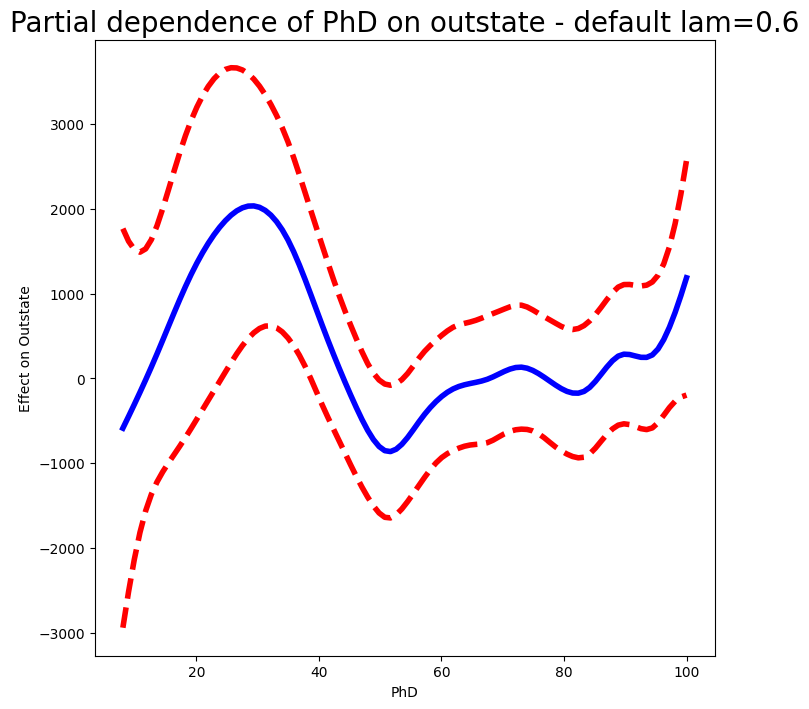

In [27]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, tup[2][0], ax=ax)
ax.set_xlabel(tup[2][1])
ax.set_ylabel('Effect on Outstate')
ax.set_title(f'Partial dependence of {tup[2][1]} on outstate - default lam=0.6', fontsize=20)

(0.2, 2.0)

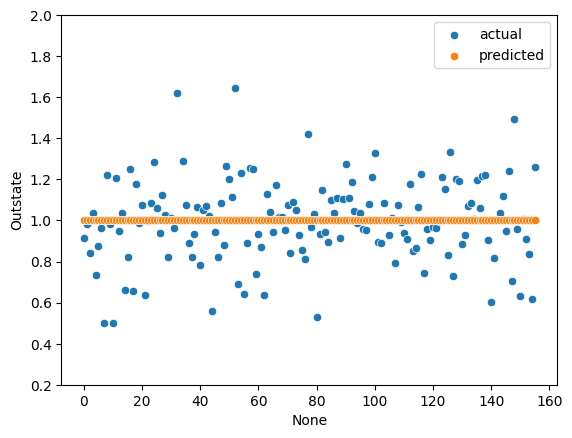

In [44]:
x_ts
y_test = pd.DataFrame()
y_test['Outstate'] = y_ts
y_ts = y_test
y_ts
x_ts.index = y_ts.index
x_ts

Xgam_ts = np.column_stack([x_ts['Expend'],
                        x_ts['Grad.Rate'],
                        x_ts['PhD'],
                        x_ts['Private'],
                        x_ts['Room.Board'],
                        x_ts['S.F.Ratio'],
                        x_ts['Terminal'],
                        x_ts['perc.alumni']])

sns.scatterplot(y=y_ts['Outstate']/gam_full.predict(Xgam_ts), x=y_ts.index, label='actual')

sns.scatterplot(y=gam_full.predict(Xgam_ts)/gam_full.predict(Xgam_ts), x=y_ts.index, label='predicted')

plt.ylim(0.2,2)
# dir(gam_full)